# 03wk-2: 로지스틱 – 로지스틱과 MSELoss, BCELoss, Adam, 로지스틱의 한계

최규빈  
2025-03-24

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/03wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wO_Mc_74QoweAxCWw5A86_&si=iWAgttM-CIgsi1x3 >}}

# 2. Imports

In [4]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [5]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 로지스틱 최초적합

## A. 로지스틱 모형

`-` $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수 있음
\<— 외우세요!!!

-   $y_i \sim {\cal B}(\pi_i),\quad$ where
    $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)} = \frac{1}{1+\exp(-w_0-w_1x_i)}$

-   $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$

`-` 회귀모형과 로지스틱 모형의 비교

-   회귀모형: $y_i \sim {\cal N}(w_0+w_1x_i, \sigma^2)$[1]
-   로지스틱:
    $y_i \sim {\cal B}\big(\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}\big)$

`-` 우리가 예측하고 싶은것

-   회귀모형: 정규분포의 평균을 예측하고 싶음. 즉 $w_0+w_1x_i$를
    예측하고 싶음. 예측값으로는 $\hat{w}_0 + \hat{w}_1x_i$를 사용!
-   로지스틱: 베르누이의 평균을 예측하고 싶음. 즉
    $\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$를 예측하고 싶음.
    예측값으로는
    $\frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}$를
    사용!

## B. 데이터

[1] 원래는 이렇게 썼었지..
$y_i = w_0 + w_1x_i + \epsilon_i \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$

In [13]:
x = torch.linspace(-1,1,2000).reshape(2000,1)
w0 = -1
w1 = 5
u = w0 + x*w1 
v = torch.exp(u) / (1+torch.exp(u)) 
y = torch.bernoulli(v)

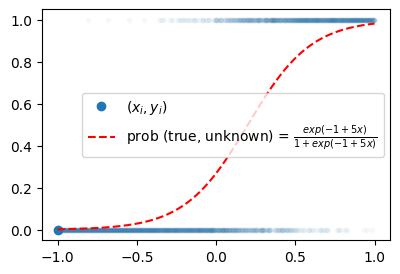

In [14]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

우리의 목적: $x_i$가 들어가면 빨간곡선 $\hat{y}_i$의 값을 만들어주는
mapping을 학습해보자.

## C. Step1: net 설계 (모델링)

`-` 최초의 곡선을 그려보자. ($net: x \to yhat$ 을 수행하는 네트워크를
설계해보자는 의미)

In [15]:
w0hat = -0.8
w1hat = -0.3

In [16]:
def sigmoid(x):
    return torch.exp(x)/(1+torch.exp(x))

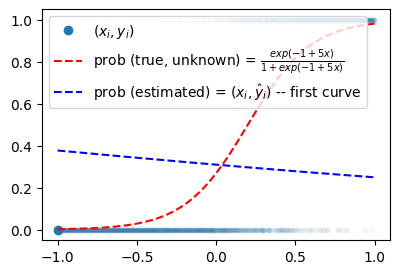

In [17]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.legend()

`-` `w0hat + w1hat*x` 이 부분을 `torch.nn.Linear(bias = False)`로 구현

In [18]:
X = torch.concat([torch.ones(2000).reshape(-1,1),x],axis=1)
l1 = torch.nn.Linear(in_features=2, out_features=1, bias = False)
l1.weight

In [19]:
l1.weight.data = torch.tensor([[-0.8,  -0.3]])

In [20]:
l1(X), w0hat + w1hat*x # 똑같죠

`-` `w0hat + w1hat*x` 이 부분을 `torch.nn.Linear(bias = True)`로 구현

In [21]:
#X = torch.concat([torch.ones(2000).reshape(-1,1),x],axis=1)
l1 = torch.nn.Linear(in_features=1, out_features=1)
l1.weight, l1.bias

In [22]:
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [23]:
l1(x), w0hat + w1hat*x # 이것도 똑같죠!

`-` 내가만든 sigmoid 대신에 토치에서 제공하는 sigmoid 사용

In [24]:
a1 = torch.nn.Sigmoid()

In [25]:
sigmoid(l1(x)), a1(l1(x)) # 똑같아요

`-` 지금까지의 구현 확인

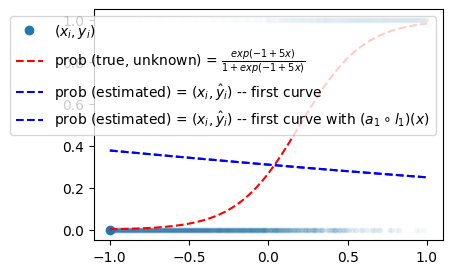

In [26]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(w0hat + w1hat*x),'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.plot(x,a1(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve with $(a_1 \circ l_1)(x)$")
plt.legend()

`-` 관찰: 지금 아래의 구조이다.

$${\boldsymbol x} \overset{l_1}{\to} {\boldsymbol u} \overset{a_1}{\to} {\boldsymbol v} = \hat{\boldsymbol y}$$

`-` 소망: 함수 $l_1, a_1$ 의 합성을 하나로 묶어서

$$(a_1\circ l_1)({\boldsymbol x}) := net({\boldsymbol x})$$

이러한 기능을 하는 하나의 함수 $net$을 만들 수 없을까?

In [27]:
net = torch.nn.Sequential(l1,a1) #l1을 취하고 그다음에 a1을 취하라는 의미

In [28]:
net(x), a1(l1(x)), sigmoid(w0hat+ w1hat*x)

`-` net 살펴보기

In [29]:
net

-   처음에는 선형변환하고, 그담에는 Sigmoid를 수행하라는 의미

`-` net 살펴보기: 고수버전 – 책 안보고 코딩배우기

In [30]:
set(dir(net)) & {'__call__', '__getitem__'}

-   좋은거 가지고 있네 ㅎㅎ
-   callable 이면서 subscriptable 오브젝트..

In [31]:
lst = [11,22,33]
lst.__getitem__(-1) # lst[-1]

In [32]:
sigmoid.__call__(x) # sigmoid(x)

In [33]:
sigmoid[0] # 난 스크립터블 하지 않은걸? (= 난 리스트처럼 인덱싱 못해요)

In [34]:
lst(x)# 난 컬러블하지 않은걸? (= 난 함수처럼 입력을 받고 출력을 주는 일은 못해요)

In [35]:
net(x) # 컬러블이면서

In [36]:
net[0],net[1] # 섭스크립터블

In [37]:
_l1, _a1 = net # 언패킹!! (섭스크립터블하니까..)

In [38]:
_l1.weight, _l1.bias # 내가 설정한 웨이트도 그대로 들어가있음

## D. Step1~4

In [56]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
#loss_fn = torch.nn.MSELoss() # -- 이 코드 일단 쓰지 않을게여
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

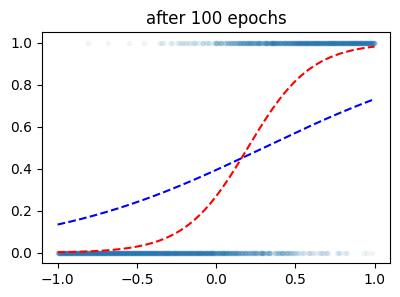

In [57]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

In [45]:
for epoc in range(4900):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

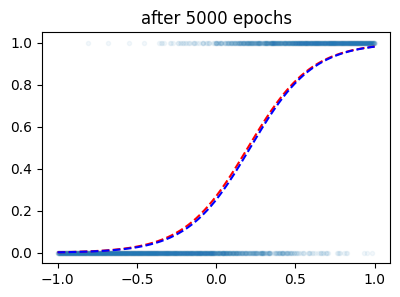

In [46]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 5000 epochs')

# 4. 학습과정 시각화 및 문제인식

## A. 시각화를 위한 준비

In [47]:
def plot_loss(loss_fn, ax=None, Wstar=[-1,5]):
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.1),torch.arange(-1,10,0.1),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    #---#
    if ax is None: 
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(w0hat,w1hat,loss,s=0.001) 
    ax.scatter(w0hat[::20],w1hat[::20],loss[::20],s=0.1,color='C0') 
    w0star,w1star = np.array(Wstar).reshape(-1)
    ax.scatter(w0star,w1star,l(w0star,w1star),s=200,marker='*',color='red',label=f"W=[{w0star:.1f},{w1star:.1f}]")
    #---#
    ax.elev = 15
    ax.dist = -20
    ax.azim = 75    
    ax.legend()
    ax.set_xlabel(r'$w_0$')  # x축 레이블 설정
    ax.set_ylabel(r'$w_1$')  # y축 레이블 설정
    ax.set_xticks([-10,-5,0])  # x축 틱 간격 설정
    ax.set_yticks([-10,0,10])  # y축 틱 간격 설정

In [48]:
def learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    What_history = []
    Whatgrad_history = []
    What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    for epoc in range(100): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        ## record 
        if epoc % 5 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
            Whatgrad_history.append([net[0].bias.grad.item(), net[0].weight.grad.item()])
        optimizr.zero_grad() 
        
    return yhat_history, loss_history, What_history, Whatgrad_history

In [49]:
def show_animation(net, loss_fn, optimizr):
    yhat_history,loss_history,What_history,Whatgrad_history = learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7.5,3.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ## ax1: 왼쪽그림 
    ax1.scatter(x,y,alpha=0.01)
    ax1.scatter(x[0],y[0],color='C0',label=r"observed data = $(x_i,y_i)$")
    ax1.plot(x,v,'--',label=r"prob (true) = $(x_i,\frac{exp(-1+5x_i)}{1+exp(-1+5x_i)})$")    
    line, = ax1.plot(x,yhat_history[0],'--',label=r"prob (estimated) = $(x_i,\hat{y}_i)$") 
    ax1.legend()
    ## ax2: 오른쪽그림 
    plot_loss(loss_fn,ax2)
    ax2.scatter(np.array(What_history)[0,0],np.array(What_history)[0,1],loss_history[0],color='blue',s=200,marker='*')    
    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        w0hat = np.array(What_history)[epoc,0]
        w1hat = np.array(What_history)[epoc,1]
        w0hatgrad = np.array(Whatgrad_history)[epoc,0]
        w1hatgrad = np.array(Whatgrad_history)[epoc,1]
        ax2.scatter(w0hat,w1hat,loss_history[epoc],color='grey')
        ax2.set_title(f"What.grad=[{w0hatgrad:.4f},{w1hatgrad:.4f}]",y=0.8)
        fig.suptitle(f"epoch={epoc*5} // What=[{w0hat:.2f},{w1hat:.2f}] // Loss={loss_fn.__class__.__name__} // Opt={optimizr.__class__.__name__}")
        return line
    ani = animation.FuncAnimation(fig, animate, frames=20)    
    plt.close()
    return ani

In [50]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

## B. 좋은 초기값

In [51]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## C. 가능성 있는 초기값

In [52]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 최악의 초기값

In [53]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

해결하는 접근법:

-   컴공스타일: 에폭을 늘려볼까?
-   산공스타일: 옵티마이저를 바꿔볼까?
-   통계스타일: Loss를 바꿔볼까?

# 5. 손실함수의 개선

## A. BCE Loss를 사용하여 학습

`-` BCE loss라는게 있음.

-   $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$
-   <https://en.wikipedia.org/wiki/Cross-entropy>

In [54]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net # 네트워크는 섭스크립터블 오브젝트이니까..
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    #loss = torch.mean((y-yhat)**2)
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

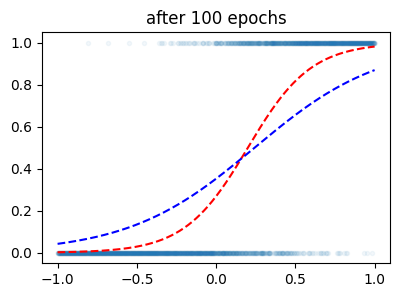

In [55]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

같은 100 에폭인데 훨씬 잘맞춤..

`-` loss수식을 못외우겠다면?

In [60]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net 
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) # yhat부터 써야함
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

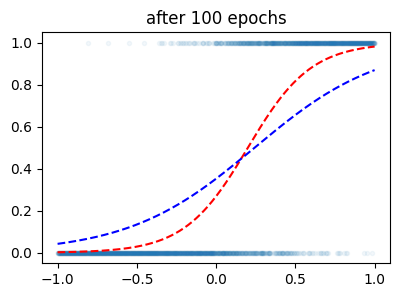

In [59]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,v,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

## B. Loss Function 시각화

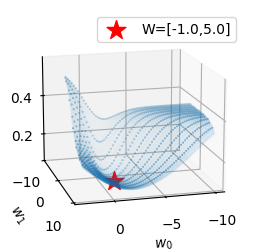

In [61]:
plot_loss(torch.nn.MSELoss())

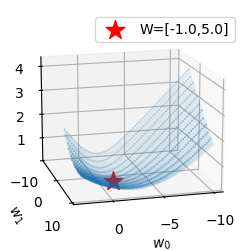

In [62]:
plot_loss(torch.nn.BCELoss())

`-` 비교해보자.

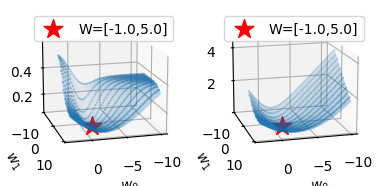

In [63]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
plot_loss(torch.nn.MSELoss(),ax1)
plot_loss(torch.nn.BCELoss(),ax2)

## C. 학습과정 시각화 – 좋은 초기값

`-` MSELoss

In [64]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [65]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss

In [70]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [71]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## E. 학습과정 시각화 – 최악의 초기값

`-` MSELoss

In [72]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [73]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

# 6. 옵티마이저의 개선

## A. 학습과정 시각화 – 좋은 초기값

`-` MSELoss + SGD

In [75]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8470])
net[0].weight.data = torch.tensor([[-0.3467]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [76]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## B. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss + SGD

In [77]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [78]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## C. 학습과정 시각화 – 최악의 초기값

`-` MSELoss + SGD

In [79]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
#---#
show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [80]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

# 7. 로지스틱의 한계

## A. 신문기사 (데이터의 모티브)

`-` [스펙이 높아도 취업이 안된다고
합니다..](https://www.joongang.co.kr/article/23637092#home)

**중소·지방 기업 “뽑아봤자 그만두니까”**

중소기업 관계자들은 고스펙 지원자를 꺼리는 이유로 높은 퇴직률을 꼽는다.
여건이 좋은 대기업으로 이직하거나 회사를 관두는 경우가 많다는
하소연이다. 고용정보원이 지난 3일 공개한 자료에 따르면 중소기업
청년취업자 가운데 49.5%가 2년 내에 회사를 그만두는 것으로 나타났다.

중소 IT업체 관계자는 “기업 입장에서 가장 뼈아픈 게 신입사원이 그만둬서
새로 뽑는 일”이라며 “명문대 나온 스펙 좋은 지원자를 뽑아놔도 1년을
채우지 않고 그만두는 사원이 대부분이라 우리도 눈을 낮춰 사람을 뽑는다”고
말했다.

## B. 가짜데이터

In [115]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

In [116]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

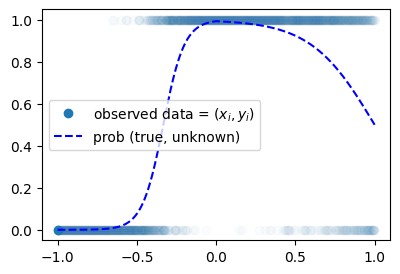

In [117]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

## C. 로지스틱으로 적합

In [85]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---# 
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

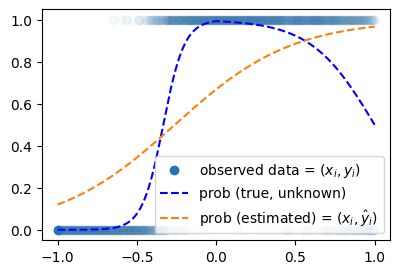

In [86]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data, '--', label= r"prob (estimated) = $(x_i,\hat{y}_i)$")
plt.legend()

`-` Epoch을 10억번으로 설정해도 이건 못 맞출것 같음.

# 8. 로지스틱의 한계 극복

## A. 아이디어

`-` sigmoid를 넣기 전의 상태가 직선이 아니라 꺽이는 직선이야 한다.

In [146]:
a = torch.nn.Sigmoid()

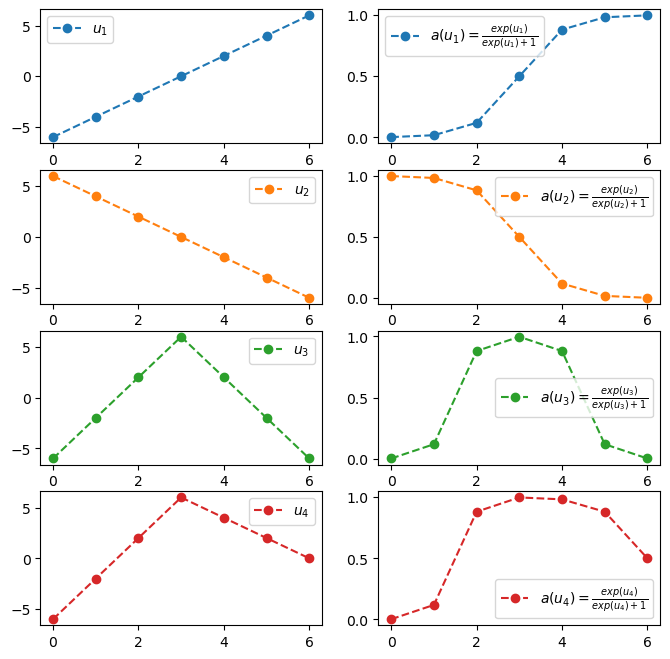

In [147]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0',label = r"$u_1$")
ax[0,0].legend()
ax[0,1].plot(a(u1),'--o',color='C0',label = r"$a(u_1)=\frac{exp(u_1)}{exp(u_1)+1}$")
ax[0,1].legend()
ax[1,0].plot(u2,'--o',color='C1',label = r"$u_2$")
ax[1,0].legend()
ax[1,1].plot(a(u2),'--o',color='C1',label = r"$a(u_2)=\frac{exp(u_2)}{exp(u_2)+1}$")
ax[1,1].legend()
ax[2,0].plot(u3,'--o',color='C2', label = r"$u_3$")
ax[2,0].legend()
ax[2,1].plot(a(u3),'--o',color='C2', label = r"$a(u_3)=\frac{exp(u_3)}{exp(u_3)+1}$")
ax[2,1].legend()
ax[3,0].plot(u4,'--o',color='C3', label = r"$u_4$")
ax[3,0].legend()
ax[3,1].plot(a(u4),'--o',color='C3', label = r"$a(u_4)=\frac{exp(u_4)}{exp(u_4)+1}$")
ax[3,1].legend()

## B. 꺽인그래프를 만드는 방법

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전에 꺽인
그래프 모양을 만드는 기술이 있어야겠음.

`-` 아래와 같은 벡터 ${\boldsymbol x}$를 가정하자.

In [2]:
x = torch.linspace(-1,1,1001).reshape(-1,1)
x

`-` 목표: 아래와 같은 벡터 ${\boldsymbol y}$를 만들어보자.

$${\boldsymbol y} = [y_1,y_2,\dots,y_{n}], \quad y_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$$

`# 방법1` – 수식 그대로 구현

In [89]:
y = x*0 
y[x<0] = (9*x+4.5)[x<0]
y[x>0] = (-4.5*x+4.5)[x>0]

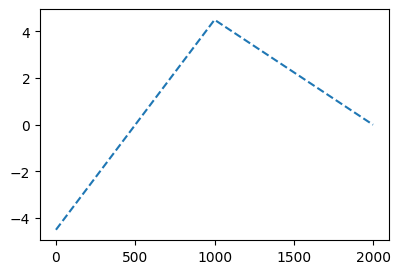

In [90]:
plt.plot(y,'--')

`#`

`# 방법2` – 렐루이용

In [92]:
relu = torch.nn.ReLU()

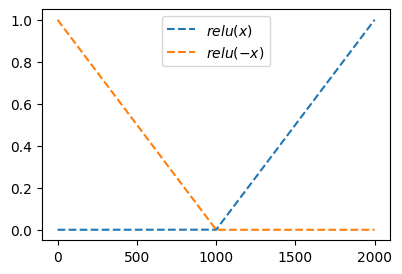

In [93]:
plt.plot(relu(x),'--',label=r'$relu(x)$')
plt.plot(relu(-x),'--',label=r'$relu(-x)$')
plt.legend()

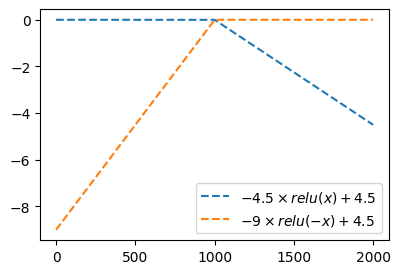

In [94]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x) + 4.5$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x) + 4.5$')
plt.legend()

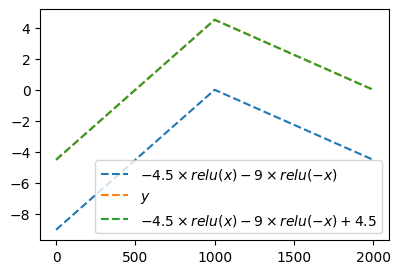

In [95]:
plt.plot(-4.5*relu(x)-9*relu(-x),'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)$')
plt.plot(y,'--',label=r'$y$')
plt.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)+4.5$')
plt.legend()

`-` 우리의 목표: 저 초록선에서 시그모이드를 태우면된다. 즉 아래의 느낌임

In [96]:
sig = torch.nn.Sigmoid()

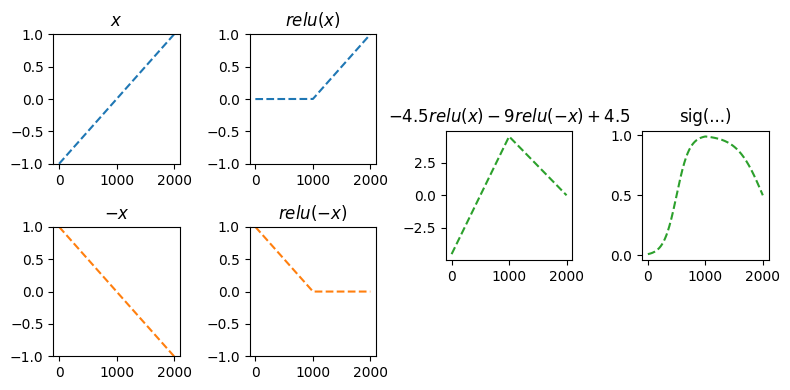

In [97]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title(r'$x$'); ax1.set_ylim(-1,1)
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title(r'$-x$'); ax2.set_ylim(-1,1)
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title(r'$relu(x)$'); ax3.set_ylim(-1,1)
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title(r'$relu(-x)$'); ax4.set_ylim(-1,1)
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title(r'$-4.5 relu(x)-9 relu(-x)+4.5$')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('sig(...)');
#---#
ax1.plot(x,'--',color='C0')
ax2.plot(-x,'--',color='C1')
ax3.plot(relu(x),'--',color='C0')
ax4.plot(relu(-x),'--',color='C1')
ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
ax6.plot(sig(-4.5*relu(x)-9*relu(-x)+4.5),'--',color='C2')
fig.tight_layout()

`#`

`# 방법3` – 방법2의 다른구현!

`-` 렐루이용하여 만드는 방법 정리

1.  벡터 x와 relu함수를 준비한다.
2.  u = \[x,-x\] 를 계산한다.
3.  v = \[relu(x), relu(-x)\] 를 계산한다.
4.  y = -4.5 \* relu(x) + 9 \* relu(-x) +4.5 를 계산한다.

`-` 1단계

In [98]:
x,relu

`-` 2단계

In [99]:
u = torch.concat([x,-x],axis=1) # u = [x, -x] 같은것
u

`-` 3단계

In [100]:
v = relu(u) # 각각의 column에 렐루취함
v

`-` 4단계

In [101]:
-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

In [102]:
y

`-` 그런데, 4단계는 아래와 같이 볼 수 있다.

-   ${\boldsymbol v}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix}
    v_{11} & v_{12}  \\
    v_{21} & v_{22}  \\
    \dots & \dots  \\
    v_{n1} & v_{n2}  \\
    \end{bmatrix}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 =
    \begin{bmatrix}
    -4.5 v_{11} - 9.0 v_{12} + 4.5  \\
    -4.5 v_{21} - 9.0 v_{22} + 4.5  \\
    \dots \\
    -4.5 v_{n1} - 9.0 v_{n2} + 4.5 \\
    \end{bmatrix}$

위의 수식을 참고하여 매트릭스의 곱 형태로 다시 포현하면 아래와 같다.

In [103]:
#-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5
What = torch.tensor([[-4.5],[-9.0]]) 
v @ What + 4.5 

이제 매트릭스의 곱 대신에 `torch.nn.Linear()`를 이용하면 아래의 코드와
같아진다.

In [104]:
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)

In [105]:
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [106]:
l2(v)

`-` 사실 2단계도 아래와 같이 볼 수 있다.

$$\begin{bmatrix}
x_1 \\
x_2 \\
\dots \\ 
x_n 
\end{bmatrix}\begin{bmatrix} 1 & -1 \end{bmatrix} = \begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n \end{bmatrix}$$

In [107]:
#u = torch.concat([x,-x],axis=1) # u1 = [x, -x] 같은것

In [108]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])

In [109]:
l1(x)

`-` 따라서 `torch.nn` 에 포함된 레이어를 이용하면 아래와 같이 표현할 할
수 있다.

In [110]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(2,1)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [111]:
l2(a1(l1(x))), y

`-` 각각의 layer를 `torch.nn.Sequential()` 로 묶으면 아래와 같이 정리할
수 있다.

In [112]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1,a1,l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [113]:
net(x),y

`#`

> **Note**
>
> ***수식표현***
>
> `(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$
>
> `(2)`
> $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$
>
> -   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
> -   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$
>
> `(3)`
> $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$
>
> `(4)`
> $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$
>
> -   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
> -   $b^{(2)}=4.5$
>
> `(5)`
> $net({\bf X})=(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

## C. Step 1~4

`-` 다시한번 데이터 정리

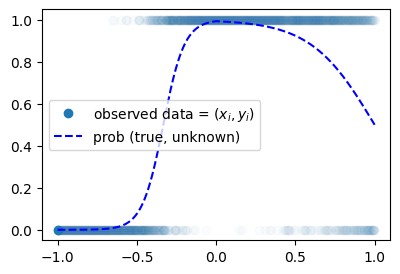

In [120]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

`-` Step1에 대한 생각: 네트워크를 어떻게 만들까? = 아키텍처를 어떻게
만들까? = 모델링

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` Step2,3,4 는 너무 뻔해서..

In [121]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

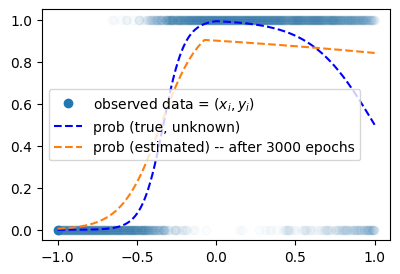

In [122]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 3000 epochs")
plt.legend()

In [123]:
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

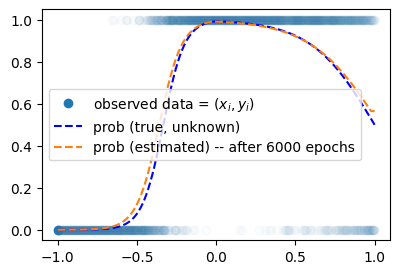

In [124]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 6000 epochs")
plt.legend()